<a href="https://colab.research.google.com/github/henry-bao/paml-final-project/blob/model_eval/src/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

YOUR_TOKEN = token
YOUR_HANDLE = handle


%mkdir /content/gdrive/MyDrive/paml
%cd /content/gdrive/MyDrive/paml
!git clone https://{YOUR_TOKEN}@github.com/henry-bao/paml-final-project.git
%cd /content/gdrive/MyDrive/paml/paml-final-project
!git checkout 'model_eval'
!git pull
%cd /content/gdrive/MyDrive/paml

PROJECT_ROOT = f"/content/gdrive/MyDrive/paml/paml-final-project"
%cd {PROJECT_ROOT}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/MyDrive/paml’: File exists
/content/gdrive/MyDrive/paml
fatal: destination path 'paml-final-project' already exists and is not an empty directory.
/content/gdrive/MyDrive/paml/paml-final-project
Already on 'model_eval'
Your branch is up to date with 'origin/model_eval'.
Already up to date.
/content/gdrive/MyDrive/paml
/content/gdrive/MyDrive/paml/paml-final-project


In [2]:
!pip install -r requirements.txt
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [3]:
# Load the data
df = pd.read_csv('data/US_Accidents_March23_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130897 entries, 0 to 130896
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               130897 non-null  int64  
 1   Start_Lat              130897 non-null  float64
 2   Start_Lng              130897 non-null  float64
 3   Street                 130897 non-null  object 
 4   City                   130897 non-null  object 
 5   County                 130897 non-null  object 
 6   State                  130897 non-null  object 
 7   Zipcode                130897 non-null  object 
 8   Timezone               130897 non-null  object 
 9   Airport_Code           130897 non-null  object 
 10  Temperature(F)         130897 non-null  float64
 11  Humidity(%)            130897 non-null  float64
 12  Pressure(in)           130897 non-null  float64
 13  Visibility(mi)         130897 non-null  float64
 14  Wind_Direction         130897 non-nu

In [4]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        num_labels = len(np.unique(y))

        # Base cases
        if depth == self.max_depth or num_labels == 1:
            return np.argmax(np.bincount(y))

        best_feature, best_threshold = self._find_best_split(X, y)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None

        _, num_features = X.shape

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                gain = self._calculate_gain(X, y, feature, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, X, y, feature, threshold):
        parent_entropy = self._calculate_entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_entropy = self._calculate_entropy(y[left_indices])
        right_entropy = self._calculate_entropy(y[right_indices])

        num_left = len(y[left_indices])
        num_right = len(y[right_indices])
        total_samples = num_left + num_right

        gain = parent_entropy - ((num_left / total_samples) * left_entropy) - ((num_right / total_samples) * right_entropy)

        return gain

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

        return entropy

    def _traverse_tree(self, x, tree):
        if isinstance(tree, dict):
            feature = tree['feature']
            threshold = tree['threshold']

            if x[feature] <= threshold:
                return self._traverse_tree(x, tree['left'])
            else:
                return self._traverse_tree(x, tree['right'])
        else:
            return tree

In [6]:
# Load the models
rf_model = load('models/random_forest_model.pkl')
dt_model = load('models/decision_tree_model.pkl')
nb_model = load('models/naive_bayes_model.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianNB from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
df = df.drop(['Zipcode', 'Airport_Code','Street'], axis=1)
df_dummy = pd.get_dummies(df, drop_first=True)

target='Severity'

y = df_dummy[target]
X = df_dummy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((104717, 9176), (104717,)), ((26180, 9176), (26180,)))

In [9]:
# Make predictions
# Random Forest
y_pred_rf = rf_model.predict(X_test)
print(y_pred_rf.shape)
y_proba_rf = rf_model.predict_proba(X_test)
print(y_proba_rf.shape)

# Decision Tree
y_pred_dt = dt_model.predict(X_test.values)

# Naive Bayes
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)

(26180,)
(26180, 4)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- City_Accident
- City_Ackworth
- City_Adams Center
- City_Airway Heights
- City_Alledonia
- ...
Feature names seen at fit time, yet now missing:
- City_Abbotsford
- City_Abbott
- City_Abernathy
- City_Abrams
- City_Absarokee
- ...


## Classification Report

In [8]:
print("Classification Report for Random Forest Model")
print(classification_report(y_test, y_pred_rf))


Classification Report for Random Forest Model
              precision    recall  f1-score   support

           1       0.81      0.91      0.86      6491
           2       0.65      0.52      0.58      6658
           3       0.62      0.67      0.65      6657
           4       0.65      0.64      0.65      6374

    accuracy                           0.69     26180
   macro avg       0.68      0.69      0.68     26180
weighted avg       0.68      0.69      0.68     26180



In [9]:
print("Classification Report for Decision Tree Model")
print(classification_report(y_test, y_pred_dt))

Classification Report for Decision Tree Model
              precision    recall  f1-score   support

           1       0.55      0.98      0.70      6491
           2       0.51      0.36      0.42      6658
           3       0.53      0.59      0.56      6657
           4       0.53      0.20      0.30      6374

    accuracy                           0.53     26180
   macro avg       0.53      0.53      0.49     26180
weighted avg       0.53      0.53      0.49     26180



In [ ]:
print("Classification Report for Naive Bayes Model")
print(classification_report(y_test, y_pred_nb))

## Confusion Matrix

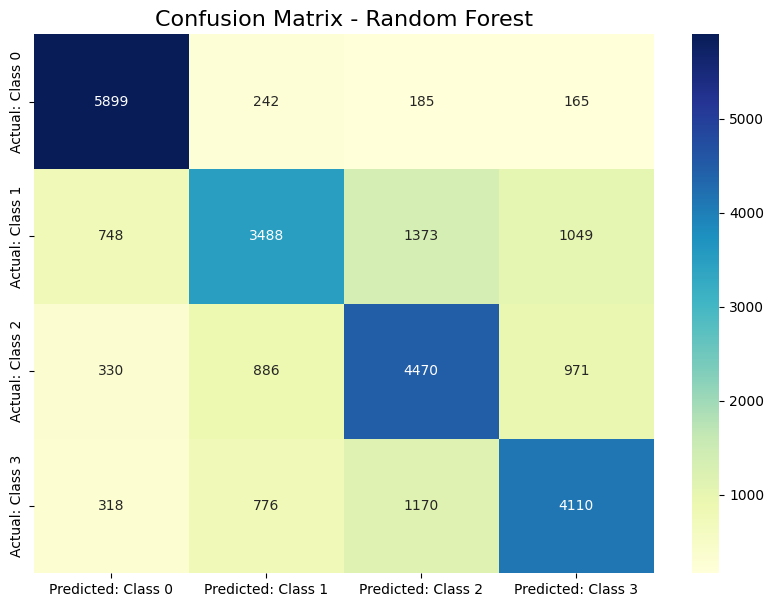

In [10]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest", fontsize=16)  # Adding title
plt.show()

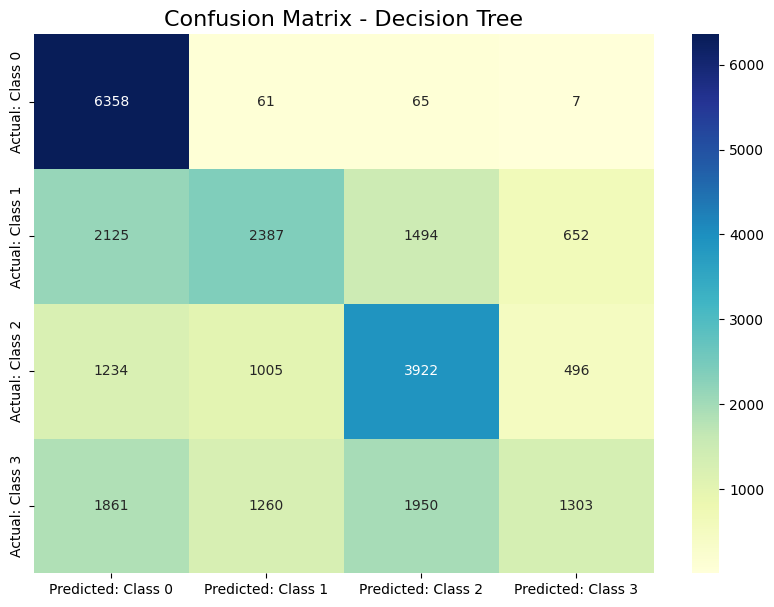

In [11]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree", fontsize=16)  # Adding title
plt.show()

In [ ]:
# Naive Bayes
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_nb)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree", fontsize=16)  # Adding title
plt.show()

## ROC Curve

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


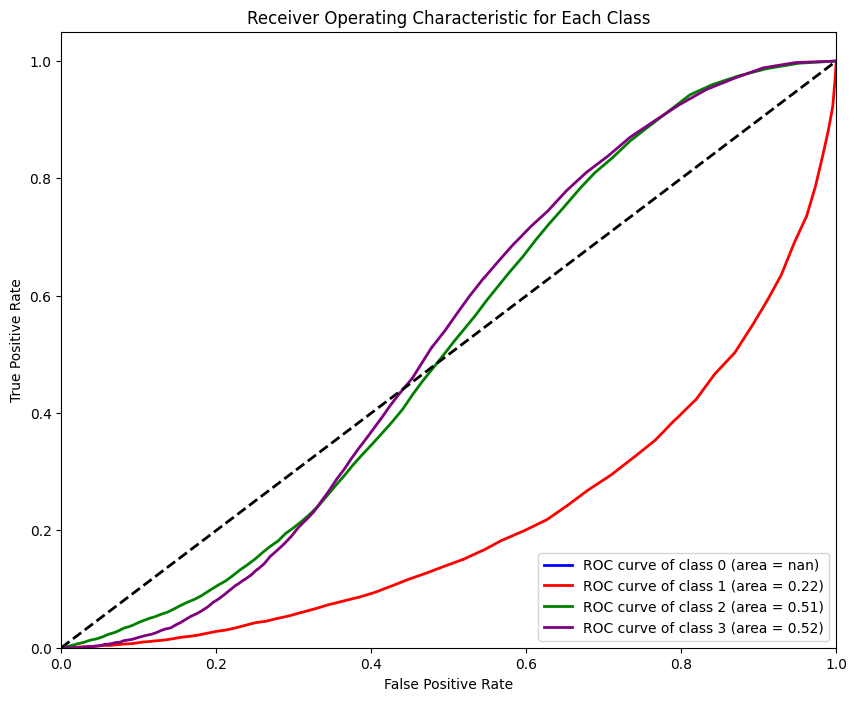

In [28]:
# Random Forest
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Calculate ROC curve and ROC area for each class
n_classes = y_proba_rf.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()




In [ ]:
# Naive Bayes
# replace y_proba_rf with y_proba_nb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

n_classes = y_proba_nb.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_nb[:, i]) # replace y_proba_rf with y_proba_nb
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

## Cross Validation

In [38]:
# Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5)  # By default, the score computed at each CV iteration is the score method of the estimator (accuracy for classifiers).

# Print the results
print("Accuracy scores for 5-fold cross-validation:")
print(scores)
print("\nAverage cross-validation score: {:.2f}".format(np.mean(scores)))




Accuracy scores for 5-fold cross-validation:
[0.68235294 0.68846448 0.69009511 0.68138584 0.68723022]

Average cross-validation score: 0.69


In [ ]:
# Decision Tree
import numpy as np
from sklearn.model_selection import KFold

# Assuming 'X' and 'y' are pandas DataFrame and Series respectively
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    # Correct indexing for pandas
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Assuming 'DecisionTree' is your model class
    model = DecisionTree(max_depth=5)  # Adjust max_depth as needed

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate accuracy or other metrics
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Display results
print("Cross-Validated Accuracies:", accuracies)
print("Average Cross-Validated Accuracy:", np.mean(accuracies))

In [ ]:
# Naive Bayes
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nb_model, X, y, cv=5)  # By default, the score computed at each CV iteration is the score method of the estimator (accuracy for classifiers).

# Print the results
print("Accuracy scores for 5-fold cross-validation:")
print(scores)
print("\nAverage cross-validation score: {:.2f}".format(np.mean(scores)))